In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Imports

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from prettytable import PrettyTable
import time
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, f1_score, recall_score
import matplotlib.pyplot as plt
import numpy as np
import wandb
from skimage.feature import hog
from skimage.filters import sobel
import seaborn as sns

# 4.1

## Reading CSV file and reshaping to 28x28 images

In [5]:
# Load the train and test CSV files
train_file_path = "drive/MyDrive/cv_a1/train.csv"
test_file_path = "drive/MyDrive/cv_a1/test.csv"

# Reading csv, converting to numpy array and extracting labels
train_rows = pd.read_csv(train_file_path).to_numpy()
test_rows = pd.read_csv(test_file_path).to_numpy()

train_labels = train_rows[:, 0]
train_pixels = train_rows[:, 1:]

test_labels = test_rows[:, 0]
test_pixels = test_rows[:, 1:]

# Reshape rows from 784 to 28x28 pixels
train_arr = train_pixels.reshape(-1, 28, 28)
test_arr = test_pixels.reshape(-1, 28, 28)

random_indices = np.random.choice(train_arr.shape[0], 10000, replace=False)
validation_arr = train_arr[random_indices]
validation_labels = train_labels[random_indices]

# Keep only the not-selected rows in train_arr and train_labels
train_arr = np.delete(train_arr, random_indices, axis=0)
train_labels = np.delete(train_labels, random_indices, axis=0)

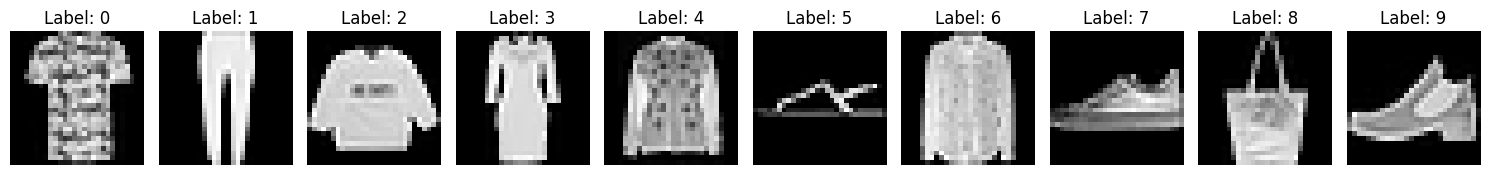

In [6]:
unique_labels = list(set(train_labels))
unique_images = list()
for unique_label in unique_labels:
    image_index = np.where(train_labels == unique_label)[0]
    unique_images.append(train_arr[image_index])

fig, ax = plt.subplots(1, len(unique_labels), figsize=(15, 5))
for i in range(len(unique_labels)):
    ax[i].imshow(unique_images[i][0], cmap='gray')
    ax[i].set_title(f"Label: {unique_labels[i]}")
    ax[i].axis('off')
plt.tight_layout()
plt.show()

After analysing each label's image I figured out the following labels:

clothing_type = {
    0: "Tshirt",
    1: "Trouser",
    2: "Sweater",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneakers",
    8: "Bag",
    9: "Boots"
}

# 4.2

## Selecting Device

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## Hyperparameters

In [8]:
# Hyperparameters
n_epochs = 20
lr = 0.001
batch_size = 64

In [9]:
# Initialize wandb
wandb.init(project="CV-A1-Q3", name="MLP_Models")

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


In [10]:
# Define 3 different MLP architectures (Hyperparameter tuning)
class MLP1(nn.Module):
    def __init__(self, input_size, num_classes):
        super(MLP1, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_size, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        return self.layers(x)

class MLP2(nn.Module):
    def __init__(self, input_size, num_classes):
        super(MLP2, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_size, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        return self.layers(x)

class MLP3(nn.Module):
    def __init__(self, input_size, num_classes):
        super(MLP3, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_size, 1024),
            nn.ReLU(),
            nn.LayerNorm(1024),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        return self.layers(x)

# Training and evaluation function
def train_and_evaluate(train_data, train_labels, val_data, val_labels, test_data, test_labels, input_size, model_name, arch_number):
    # Prepare DataLoaders
    train_dataset = TensorDataset(torch.tensor(train_data, dtype=torch.float32), torch.tensor(train_labels, dtype=torch.long))
    val_dataset = TensorDataset(torch.tensor(val_data, dtype=torch.float32), torch.tensor(val_labels, dtype=torch.long))
    test_dataset = TensorDataset(torch.tensor(test_data, dtype=torch.float32), torch.tensor(test_labels, dtype=torch.long))

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # Define model, loss, and optimizer
    num_classes = len(unique_labels)
    if arch_number == 1:
        model = MLP1(input_size, num_classes)
    elif arch_number == 2:
        model = MLP2(input_size, num_classes)
    elif arch_number == 3:
        model = MLP3(input_size, num_classes)
    else:
        raise ValueError("Invalid model number")
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    # Track metrics
    train_losses = []
    val_losses = []

    # Train the model
    for epoch in range(n_epochs):
        model.train()
        epoch_train_loss = 0.0

        for batch_data, batch_labels in train_loader:
            batch_data, batch_labels = batch_data.to(device), batch_labels.to(device)
            optimizer.zero_grad()
            outputs = model(batch_data)
            loss = criterion(outputs, batch_labels)
            loss.backward()
            optimizer.step()
            epoch_train_loss += loss.item()

        # Validate the model
        model.eval()
        epoch_val_loss = 0.0
        with torch.no_grad():
            for val_data, val_labels in val_loader:
                val_data, val_labels = val_data.to(device), val_labels.to(device)
                val_outputs = model(val_data)
                loss = criterion(val_outputs, val_labels)
                epoch_val_loss += loss.item()

        # Calculate average losses
        avg_train_loss = epoch_train_loss / len(train_loader)
        avg_val_loss = epoch_val_loss / len(val_loader)
        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)

        # Print losses after every epoch
        print(f"Epoch {epoch+1}/{n_epochs}")
        print(f"  Train Loss: {avg_train_loss:.4f}")
        print(f"  Validation Loss: {avg_val_loss:.4f}")

        # Log metrics to wandb
        wandb.log({f"{model_name}_train_loss": avg_train_loss, f"{model_name}_val_loss": avg_val_loss})

    # Evaluate on the test set
    model.eval()
    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for test_data, test_labels in test_loader:
            test_data, test_labels = test_data.to(device), test_labels.to(device)
            test_outputs = model(test_data)
            test_predictions = test_outputs.argmax(dim=1)
            all_labels.extend(test_labels.cpu().numpy())
            all_predictions.extend(test_predictions.cpu().numpy())

    # Compute test metrics
    accuracy = accuracy_score(all_labels, all_predictions)
    precision = precision_score(all_labels, all_predictions, average='weighted', zero_division=0)
    recall = recall_score(all_labels, all_predictions, average='weighted', zero_division=0)
    f1 = f1_score(all_labels, all_predictions, average='weighted')
    conf_matrix = confusion_matrix(all_labels, all_predictions)

    with open(f"drive/MyDrive/cv_a1/outputs/{model_name}_metrics.txt", "w") as f:
        f.write(f"Test Accuracy: {accuracy:.4f}\n")
        f.write(f"Test Precision: {precision:.4f}\n")
        f.write(f"Test Recall: {recall:.4f}\n")
        f.write(f"Test F1-Score: {f1:.4f}\n")
        f.write("Confusion Matrix:\n")
        f.write(str(conf_matrix) + "\n")
        f.write("Classification Report:\n")
        f.write(str(classification_report(all_labels, all_predictions, zero_division=0)) + "\n")

    # Print test metrics
    print(f"Test Accuracy: {accuracy:.4f}")
    print(f"Test Precision: {precision:.4f}")
    print(f"Test Recall: {recall:.4f}")
    print(f"Test F1-Score: {f1:.4f}")
    print("Confusion Matrix:\n", conf_matrix)
    print("Classification Report:\n", classification_report(all_labels, all_predictions, zero_division=0))

    # Log test metrics to wandb
    wandb.log({f"{model_name}_test_accuracy": accuracy, f"{model_name}_test_precision": precision, f"{model_name}_test_recall": recall, f"{model_name}_test_f1": f1})

    # Plot metrics
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Train Loss', color='blue', marker='o')
    plt.plot(val_losses, label='Validation Loss', color='orange', marker='o')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title(f'{model_name} Loss Curve')
    plt.legend()
    plt.grid()
    plt.savefig(f"drive/MyDrive/cv_a1/outputs/{model_name}_loss_curve.png")
    plt.show()

    return {
        "test_accuracy": accuracy,
        "test_precision": precision,
        "test_recall": recall,
        "test_f1": f1,
        "confusion_matrix": conf_matrix,
        "classification_report": classification_report(all_labels, all_predictions, zero_division=0)
    }

Test all 3 different models on all 3 different architectures

In [11]:
# Data preparation for all 3 different models
# Preprocess data for M1
train_data1 = train_arr.reshape(train_arr.shape[0], -1)
val_data1 = validation_arr.reshape(validation_arr.shape[0], -1)
test_data1 = test_arr.reshape(test_arr.shape[0], -1)

# Preprocess data for M2
train_data2 = np.array([sobel(img) for img in train_arr]).reshape(train_arr.shape[0], -1)
val_data2 = np.array([sobel(img) for img in validation_arr]).reshape(validation_arr.shape[0], -1)
test_data2 = np.array([sobel(img) for img in test_arr]).reshape(test_arr.shape[0], -1)

# Preprocess data for M3
train_data3 = np.array([hog(img, pixels_per_cell=(4, 4), cells_per_block=(2, 2), feature_vector=True) for img in train_arr])
val_data3 = np.array([hog(img, pixels_per_cell=(4, 4), cells_per_block=(2, 2), feature_vector=True) for img in validation_arr])
test_data3 = np.array([hog(img, pixels_per_cell=(4, 4), cells_per_block=(2, 2), feature_vector=True) for img in test_arr])

Epoch 1/20
  Train Loss: 0.6674
  Validation Loss: 0.4714
Epoch 2/20
  Train Loss: 0.4089
  Validation Loss: 0.3932
Epoch 3/20
  Train Loss: 0.3726
  Validation Loss: 0.4141
Epoch 4/20
  Train Loss: 0.3525
  Validation Loss: 0.3989
Epoch 5/20
  Train Loss: 0.3352
  Validation Loss: 0.3613
Epoch 6/20
  Train Loss: 0.3278
  Validation Loss: 0.3567
Epoch 7/20
  Train Loss: 0.3160
  Validation Loss: 0.3565
Epoch 8/20
  Train Loss: 0.3073
  Validation Loss: 0.3695
Epoch 9/20
  Train Loss: 0.2984
  Validation Loss: 0.3580
Epoch 10/20
  Train Loss: 0.2935
  Validation Loss: 0.3867
Epoch 11/20
  Train Loss: 0.2910
  Validation Loss: 0.3574
Epoch 12/20
  Train Loss: 0.2779
  Validation Loss: 0.3570
Epoch 13/20
  Train Loss: 0.2792
  Validation Loss: 0.3439
Epoch 14/20
  Train Loss: 0.2707
  Validation Loss: 0.3297
Epoch 15/20
  Train Loss: 0.2701
  Validation Loss: 0.3634
Epoch 16/20
  Train Loss: 0.2619
  Validation Loss: 0.3806
Epoch 17/20
  Train Loss: 0.2640
  Validation Loss: 0.3495
Epoch 

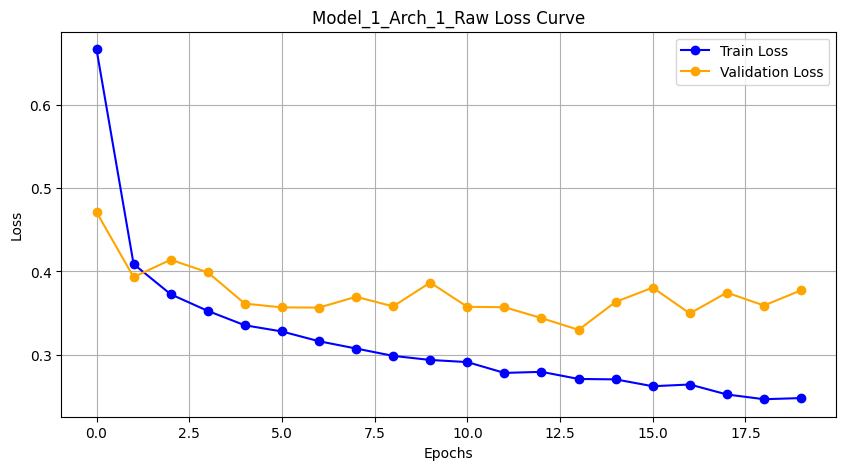

In [12]:
# Model 1 Architecture 1
# Train and evaluate M1 A1
metrics_m1a1 = train_and_evaluate(train_data1, train_labels, val_data1, validation_labels, test_data1, test_labels, input_size=28*28, model_name="Model_1_Arch_1_Raw", arch_number=1)

Epoch 1/20
  Train Loss: 2.3179
  Validation Loss: 2.3252
Epoch 2/20
  Train Loss: 2.3123
  Validation Loss: 2.3091
Epoch 3/20
  Train Loss: 2.3106
  Validation Loss: 2.3101
Epoch 4/20
  Train Loss: 2.3099
  Validation Loss: 2.3407
Epoch 5/20
  Train Loss: 2.3099
  Validation Loss: 2.3300
Epoch 6/20
  Train Loss: 2.3088
  Validation Loss: 2.3261
Epoch 7/20
  Train Loss: 2.3080
  Validation Loss: 2.3056
Epoch 8/20
  Train Loss: 2.3073
  Validation Loss: 2.3125
Epoch 9/20
  Train Loss: 2.3066
  Validation Loss: 2.3324
Epoch 10/20
  Train Loss: 2.3057
  Validation Loss: 2.3053
Epoch 11/20
  Train Loss: 2.3056
  Validation Loss: 2.3041
Epoch 12/20
  Train Loss: 2.3050
  Validation Loss: 2.3043
Epoch 13/20
  Train Loss: 2.3044
  Validation Loss: 2.3054
Epoch 14/20
  Train Loss: 2.3040
  Validation Loss: 2.3057
Epoch 15/20
  Train Loss: 2.3036
  Validation Loss: 2.4106
Epoch 16/20
  Train Loss: 2.3033
  Validation Loss: 2.3029
Epoch 17/20
  Train Loss: 2.3033
  Validation Loss: 2.3045
Epoch 

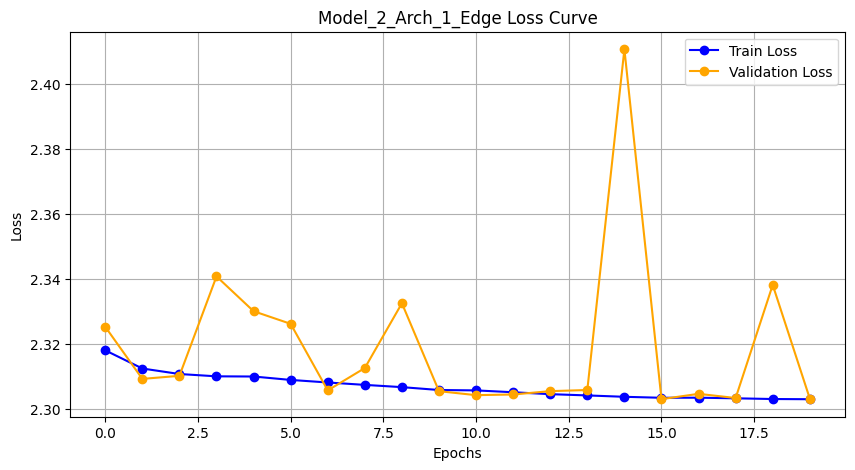

In [13]:
# Model 2 Architecture 1
# Train and evaluate M2 A1
metrics_m2a1 = train_and_evaluate(train_data2, train_labels, val_data2, validation_labels, test_data2, test_labels, input_size=28*28, model_name="Model_2_Arch_1_Edge", arch_number=2)

Epoch 1/20
  Train Loss: 0.4580
  Validation Loss: 0.3440
Epoch 2/20
  Train Loss: 0.3241
  Validation Loss: 0.3523
Epoch 3/20
  Train Loss: 0.2824
  Validation Loss: 0.3160
Epoch 4/20
  Train Loss: 0.2505
  Validation Loss: 0.3320
Epoch 5/20
  Train Loss: 0.2242
  Validation Loss: 0.2945
Epoch 6/20
  Train Loss: 0.2031
  Validation Loss: 0.3087
Epoch 7/20
  Train Loss: 0.1846
  Validation Loss: 0.3051
Epoch 8/20
  Train Loss: 0.1619
  Validation Loss: 0.3425
Epoch 9/20
  Train Loss: 0.1455
  Validation Loss: 0.3322
Epoch 10/20
  Train Loss: 0.1358
  Validation Loss: 0.3648
Epoch 11/20
  Train Loss: 0.1191
  Validation Loss: 0.3618
Epoch 12/20
  Train Loss: 0.1064
  Validation Loss: 0.4004
Epoch 13/20
  Train Loss: 0.0958
  Validation Loss: 0.4123
Epoch 14/20
  Train Loss: 0.0840
  Validation Loss: 0.4625
Epoch 15/20
  Train Loss: 0.0744
  Validation Loss: 0.5313
Epoch 16/20
  Train Loss: 0.0702
  Validation Loss: 0.4822
Epoch 17/20
  Train Loss: 0.0611
  Validation Loss: 0.4680
Epoch 

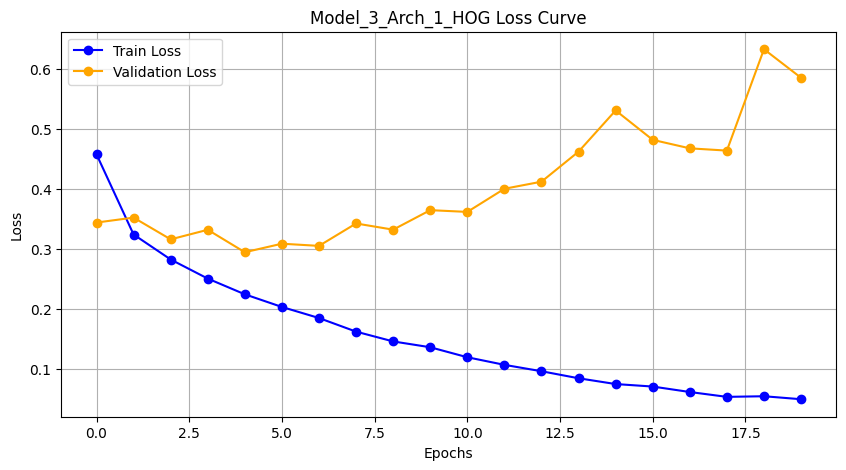

In [14]:
# Model 3 Architecture 1
# Train and evaluate M3 A1
metrics_m3a1 = train_and_evaluate(train_data3, train_labels, val_data3, validation_labels, test_data3, test_labels, input_size=train_data3.shape[1], model_name="Model_3_Arch_1_HOG", arch_number=3)

Epoch 1/20
  Train Loss: 0.5283
  Validation Loss: 0.3897
Epoch 2/20
  Train Loss: 0.4021
  Validation Loss: 0.3548
Epoch 3/20
  Train Loss: 0.3696
  Validation Loss: 0.3301
Epoch 4/20
  Train Loss: 0.3473
  Validation Loss: 0.3592
Epoch 5/20
  Train Loss: 0.3310
  Validation Loss: 0.3375
Epoch 6/20
  Train Loss: 0.3102
  Validation Loss: 0.3345
Epoch 7/20
  Train Loss: 0.2989
  Validation Loss: 0.3151
Epoch 8/20
  Train Loss: 0.2876
  Validation Loss: 0.3069
Epoch 9/20
  Train Loss: 0.2771
  Validation Loss: 0.2973
Epoch 10/20
  Train Loss: 0.2710
  Validation Loss: 0.3065
Epoch 11/20
  Train Loss: 0.2579
  Validation Loss: 0.2951
Epoch 12/20
  Train Loss: 0.2526
  Validation Loss: 0.3086
Epoch 13/20
  Train Loss: 0.2445
  Validation Loss: 0.2897
Epoch 14/20
  Train Loss: 0.2391
  Validation Loss: 0.2895
Epoch 15/20
  Train Loss: 0.2325
  Validation Loss: 0.2909
Epoch 16/20
  Train Loss: 0.2231
  Validation Loss: 0.2827
Epoch 17/20
  Train Loss: 0.2193
  Validation Loss: 0.2956
Epoch 

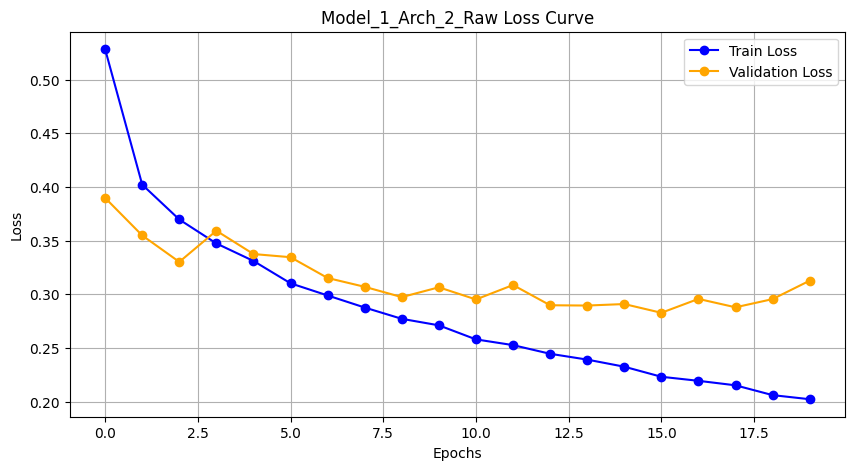

In [15]:
# Model 1 Architecture 2
# Train and evaluate M1 A2
metrics_m1a2 = train_and_evaluate(train_data1, train_labels, val_data1, validation_labels, test_data1, test_labels, input_size=28*28, model_name="Model_1_Arch_2_Raw", arch_number=2)

Epoch 1/20
  Train Loss: 2.3197
  Validation Loss: 2.3207
Epoch 2/20
  Train Loss: 2.3103
  Validation Loss: 2.3184
Epoch 3/20
  Train Loss: 2.3097
  Validation Loss: 2.4773
Epoch 4/20
  Train Loss: 2.3089
  Validation Loss: 2.3160
Epoch 5/20
  Train Loss: 2.3086
  Validation Loss: 2.3187
Epoch 6/20
  Train Loss: 2.3077
  Validation Loss: 2.3116
Epoch 7/20
  Train Loss: 2.3070
  Validation Loss: 2.3077
Epoch 8/20
  Train Loss: 2.3064
  Validation Loss: 2.3083
Epoch 9/20
  Train Loss: 2.3057
  Validation Loss: 2.3061
Epoch 10/20
  Train Loss: 2.3050
  Validation Loss: 2.3170
Epoch 11/20
  Train Loss: 2.3045
  Validation Loss: 2.3253
Epoch 12/20
  Train Loss: 2.3040
  Validation Loss: 2.3029
Epoch 13/20
  Train Loss: 2.3038
  Validation Loss: 2.4194
Epoch 14/20
  Train Loss: 2.3035
  Validation Loss: 2.3038
Epoch 15/20
  Train Loss: 2.3035
  Validation Loss: 2.3030
Epoch 16/20
  Train Loss: 2.3032
  Validation Loss: 2.3032
Epoch 17/20
  Train Loss: 2.3030
  Validation Loss: 2.3036
Epoch 

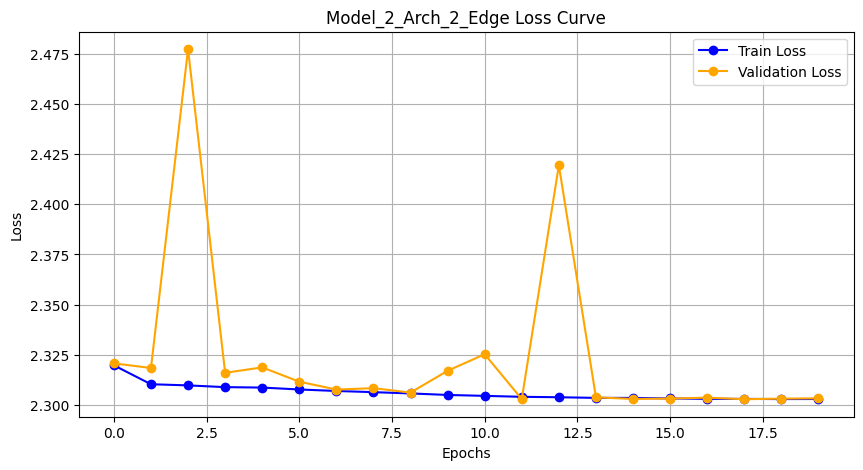

In [16]:
# Model 2 Architecture 2
# Train and evaluate M2 A2
metrics_m2a2 = train_and_evaluate(train_data2, train_labels, val_data2, validation_labels, test_data2, test_labels, input_size=28*28, model_name="Model_2_Arch_2_Edge", arch_number=2)

Epoch 1/20
  Train Loss: 0.4320
  Validation Loss: 0.3104
Epoch 2/20
  Train Loss: 0.3126
  Validation Loss: 0.3027
Epoch 3/20
  Train Loss: 0.2799
  Validation Loss: 0.2798
Epoch 4/20
  Train Loss: 0.2541
  Validation Loss: 0.2753
Epoch 5/20
  Train Loss: 0.2313
  Validation Loss: 0.2792
Epoch 6/20
  Train Loss: 0.2103
  Validation Loss: 0.2744
Epoch 7/20
  Train Loss: 0.1938
  Validation Loss: 0.2757
Epoch 8/20
  Train Loss: 0.1769
  Validation Loss: 0.2848
Epoch 9/20
  Train Loss: 0.1665
  Validation Loss: 0.2808
Epoch 10/20
  Train Loss: 0.1491
  Validation Loss: 0.2876
Epoch 11/20
  Train Loss: 0.1370
  Validation Loss: 0.3054
Epoch 12/20
  Train Loss: 0.1252
  Validation Loss: 0.3084
Epoch 13/20
  Train Loss: 0.1232
  Validation Loss: 0.3082
Epoch 14/20
  Train Loss: 0.1074
  Validation Loss: 0.3250
Epoch 15/20
  Train Loss: 0.1034
  Validation Loss: 0.3241
Epoch 16/20
  Train Loss: 0.0947
  Validation Loss: 0.3334
Epoch 17/20
  Train Loss: 0.0869
  Validation Loss: 0.3475
Epoch 

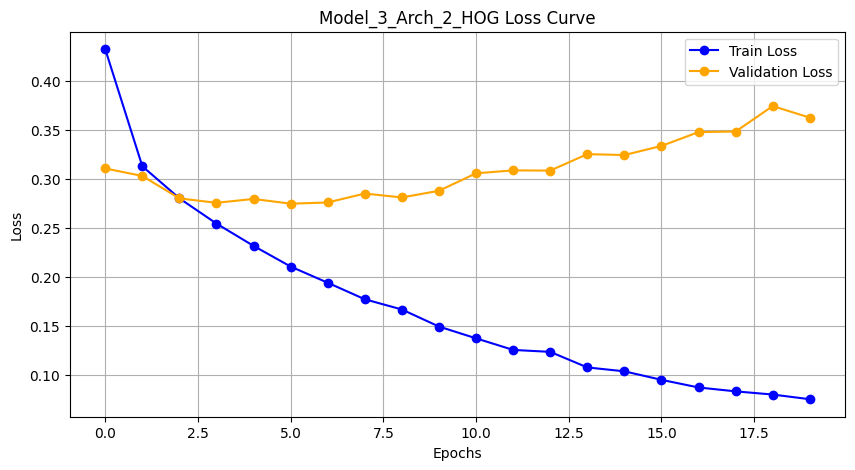

In [17]:
# Model 3 Architecture 2
# Train and evaluate M3 A2
metrics_m3a2 = train_and_evaluate(train_data3, train_labels, val_data3, validation_labels, test_data3, test_labels, input_size=train_data3.shape[1], model_name="Model_3_Arch_2_HOG", arch_number=2)

Epoch 1/20
  Train Loss: 0.5606
  Validation Loss: 0.4296
Epoch 2/20
  Train Loss: 0.4078
  Validation Loss: 0.4005
Epoch 3/20
  Train Loss: 0.3665
  Validation Loss: 0.3570
Epoch 4/20
  Train Loss: 0.3389
  Validation Loss: 0.3589
Epoch 5/20
  Train Loss: 0.3174
  Validation Loss: 0.3388
Epoch 6/20
  Train Loss: 0.3026
  Validation Loss: 0.3461
Epoch 7/20
  Train Loss: 0.2881
  Validation Loss: 0.3369
Epoch 8/20
  Train Loss: 0.2817
  Validation Loss: 0.3390
Epoch 9/20
  Train Loss: 0.2712
  Validation Loss: 0.3535
Epoch 10/20
  Train Loss: 0.2627
  Validation Loss: 0.3142
Epoch 11/20
  Train Loss: 0.2534
  Validation Loss: 0.3286
Epoch 12/20
  Train Loss: 0.2502
  Validation Loss: 0.3156
Epoch 13/20
  Train Loss: 0.2374
  Validation Loss: 0.3125
Epoch 14/20
  Train Loss: 0.2309
  Validation Loss: 0.3546
Epoch 15/20
  Train Loss: 0.2250
  Validation Loss: 0.3275
Epoch 16/20
  Train Loss: 0.2189
  Validation Loss: 0.3378
Epoch 17/20
  Train Loss: 0.2157
  Validation Loss: 0.3162
Epoch 

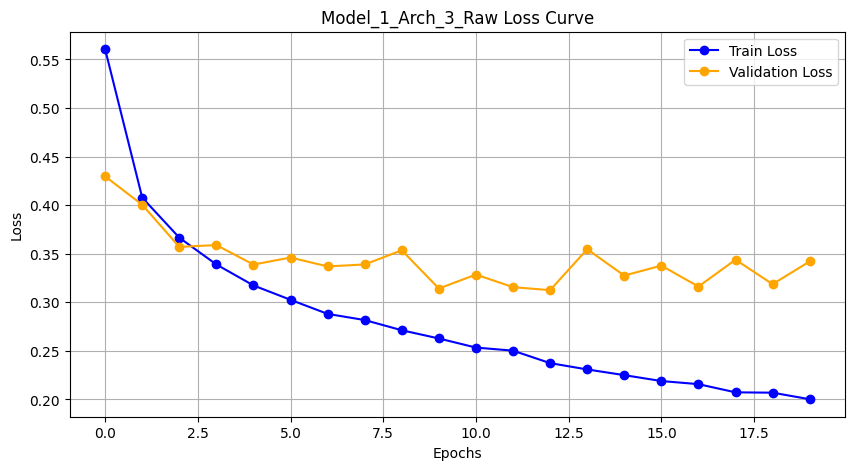

In [18]:
# Model 1 Architecture 3
# Train and evaluate M1 A3
metrics_m1a3 = train_and_evaluate(train_data1, train_labels, val_data1, validation_labels, test_data1, test_labels, input_size=28*28, model_name="Model_1_Arch_3_Raw", arch_number=3)

Epoch 1/20
  Train Loss: 2.3047
  Validation Loss: 2.3031
Epoch 2/20
  Train Loss: 2.3028
  Validation Loss: 2.3030
Epoch 3/20
  Train Loss: 2.3028
  Validation Loss: 2.3027
Epoch 4/20
  Train Loss: 2.3028
  Validation Loss: 2.3028
Epoch 5/20
  Train Loss: 2.3027
  Validation Loss: 2.3028
Epoch 6/20
  Train Loss: 2.3027
  Validation Loss: 2.3027
Epoch 7/20
  Train Loss: 2.3027
  Validation Loss: 2.3027
Epoch 8/20
  Train Loss: 2.3028
  Validation Loss: 2.3028
Epoch 9/20
  Train Loss: 2.3028
  Validation Loss: 2.3027
Epoch 10/20
  Train Loss: 2.3027
  Validation Loss: 2.3027
Epoch 11/20
  Train Loss: 2.3027
  Validation Loss: 2.3028
Epoch 12/20
  Train Loss: 2.3027
  Validation Loss: 2.3027
Epoch 13/20
  Train Loss: 2.3027
  Validation Loss: 2.3028
Epoch 14/20
  Train Loss: 2.3027
  Validation Loss: 2.3027
Epoch 15/20
  Train Loss: 2.3028
  Validation Loss: 2.3027
Epoch 16/20
  Train Loss: 2.3027
  Validation Loss: 2.3028
Epoch 17/20
  Train Loss: 2.3027
  Validation Loss: 2.3027
Epoch 

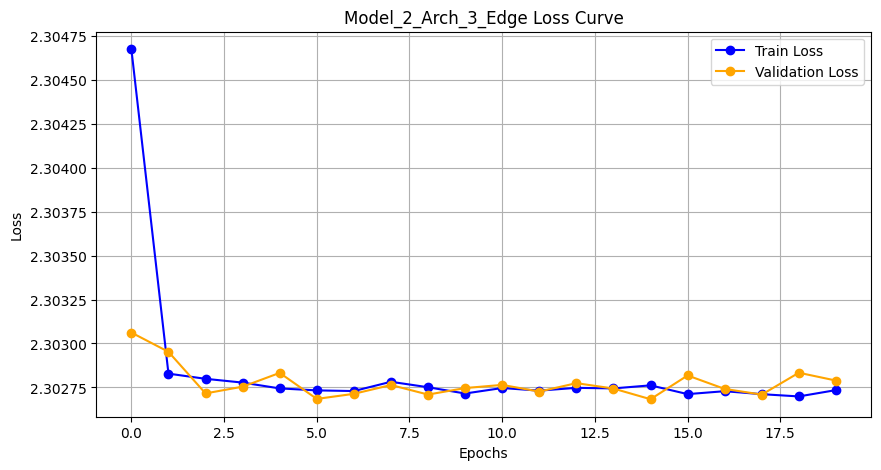

In [19]:
# Model 2 Architecture 3
# Train and evaluate M2 A3
metrics_m2a3 = train_and_evaluate(train_data2, train_labels, val_data2, validation_labels, test_data2, test_labels, input_size=28*28, model_name="Model_2_Arch_3_Edge", arch_number=3)

Epoch 1/20
  Train Loss: 0.4640
  Validation Loss: 0.3473
Epoch 2/20
  Train Loss: 0.3236
  Validation Loss: 0.3398
Epoch 3/20
  Train Loss: 0.2818
  Validation Loss: 0.3086
Epoch 4/20
  Train Loss: 0.2518
  Validation Loss: 0.3297
Epoch 5/20
  Train Loss: 0.2290
  Validation Loss: 0.2974
Epoch 6/20
  Train Loss: 0.2027
  Validation Loss: 0.3121
Epoch 7/20
  Train Loss: 0.1826
  Validation Loss: 0.3125
Epoch 8/20
  Train Loss: 0.1655
  Validation Loss: 0.3498
Epoch 9/20
  Train Loss: 0.1451
  Validation Loss: 0.3372
Epoch 10/20
  Train Loss: 0.1330
  Validation Loss: 0.3880
Epoch 11/20
  Train Loss: 0.1182
  Validation Loss: 0.3842
Epoch 12/20
  Train Loss: 0.1041
  Validation Loss: 0.4812
Epoch 13/20
  Train Loss: 0.0983
  Validation Loss: 0.4008
Epoch 14/20
  Train Loss: 0.0879
  Validation Loss: 0.4150
Epoch 15/20
  Train Loss: 0.0775
  Validation Loss: 0.4091
Epoch 16/20
  Train Loss: 0.0705
  Validation Loss: 0.5195
Epoch 17/20
  Train Loss: 0.0663
  Validation Loss: 0.5359
Epoch 

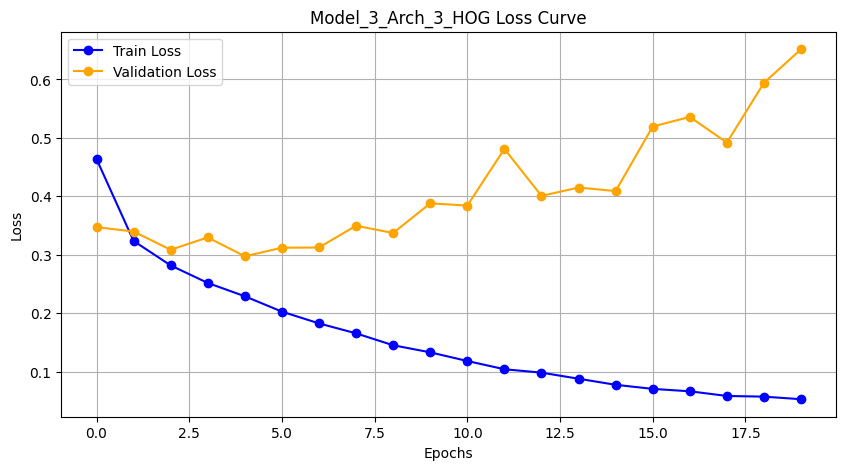

In [20]:
# Model 3 Architecture 3
# Train and evaluate M3 A3
metrics_m3a3 = train_and_evaluate(train_data3, train_labels, val_data3, validation_labels, test_data3, test_labels, input_size=train_data3.shape[1], model_name="Model_3_Arch_3_HOG", arch_number=3)

# 4.3

Summary table:
+-------+----------+-----------+--------+----------+
| Model | Accuracy | Precision | Recall | F1 Score |
+-------+----------+-----------+--------+----------+
|  m1a1 |  0.8837  |   0.8863  | 0.8837 |  0.8829  |
|  m1a2 |  0.8946  |   0.8972  | 0.8946 |  0.8937  |
|  m1a3 |  0.8893  |   0.8922  | 0.8893 |  0.8886  |
|  m2a1 |   0.1    |    0.01   |  0.1   |  0.0182  |
|  m2a2 |   0.1    |    0.01   |  0.1   |  0.0182  |
|  m2a3 |   0.1    |    0.01   |  0.1   |  0.0182  |
|  m3a1 |  0.9021  |   0.9062  | 0.9021 |  0.9032  |
|  m3a2 |  0.9127  |   0.9123  | 0.9127 |  0.9124  |
|  m3a3 |  0.8968  |   0.9011  | 0.8968 |  0.8972  |
+-------+----------+-----------+--------+----------+


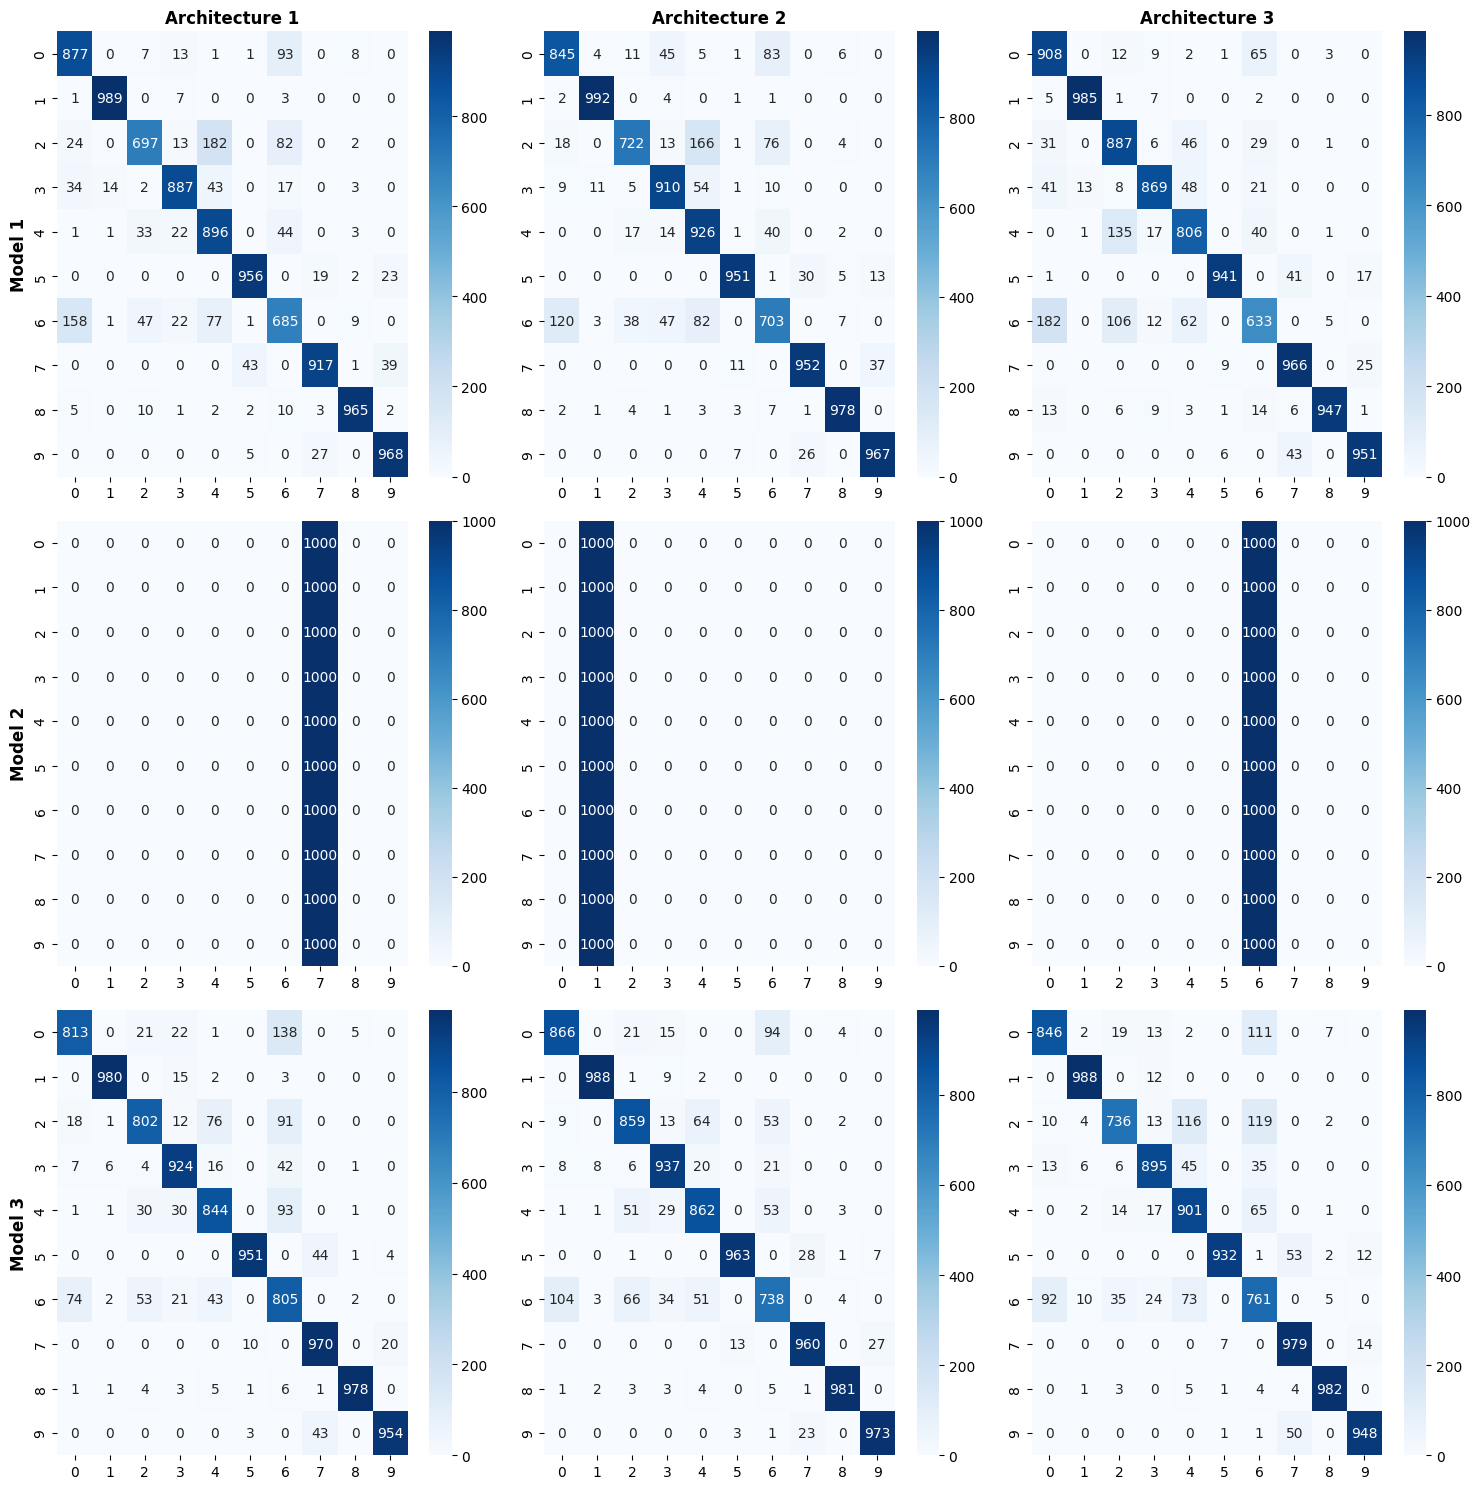

In [21]:
table = PrettyTable()
table.field_names = ["Model", "Accuracy", "Precision", "Recall", "F1 Score"]

models = ['m1a1', 'm1a2', 'm1a3',
          'm2a1', 'm2a2', 'm2a3',
          'm3a1', 'm3a2', 'm3a3']

metrics = [metrics_m1a1, metrics_m1a2, metrics_m1a3,
           metrics_m2a1, metrics_m2a2, metrics_m2a3,
           metrics_m3a1, metrics_m3a2, metrics_m3a3]

fig, axes = plt.subplots(3, 3, figsize=(15, 15))

for i in range(9):
    row = i // 3
    col = i % 3
    model = models[i]
    metric = metrics[i]
    table.add_row([model, round(metric['test_accuracy'], 4), round(metric['test_precision'], 4), round(metric["test_recall"], 4), round(metric['test_f1'], 4)])
    conf_matrix = metric["confusion_matrix"]
    sns.heatmap(conf_matrix,
                annot=True,
                fmt='d',
                cmap='Blues',
                ax=axes[row, col])

print("Summary table:")
print(table)

# Row labels
row_labels = ['Model 1', 'Model 2', 'Model 3']

# Column labels
col_labels = ['Architecture 1', 'Architecture 2', 'Architecture 3']

# Set row labels
for ax, row_label in zip(axes[:,0], row_labels):
    ax.set_ylabel(row_label, rotation=90, size=12, fontweight='bold')

# Set column labels
for ax, col_label in zip(axes[0,:], col_labels):
    ax.set_title(col_label, size=12, fontweight='bold')

plt.tight_layout()
plt.show()

> For the convergence pattern of the three models we can see that model 2 (edge features) is hardly learning any thing as the train loss is stagnant throughout and while predicting as well it predicts all the input to belong to a single class. On the other hand model 1 shows a slow convergence while model 3 shows a pretty fast convergence to the optimal point after which the validation loss starts to increase (while the training loss is still decreasing) which indicates overfitting, so we can say that model 1 is learning slowly, model 2 is not learning anything at all and model 3 is learning rapidly and reaching the optimal point rapidly as well. We can see that across architectures each model is quite consistent in the learning.

> The reason for model 2 to not learn anything may be due to the fact that while detecting edges most of the infomation is discarded and only the thin edge lines remain which does not produce much loss when calculating the loss function as most of the vector still coincides with the true label (empty spaces).

> Also the point that model 1 is reaching the optimal value slowly is due to the fact that instead of providing the actual image directly we are passing the extracted hog features to the model thus one step of preprocessing is already done and some non useful information has already been discarded.

> We can also see from the confusion matrix that all the models and architectures are consistently getting confused between the 6th and 0th classes which is tshirt and shirt which makes sense.

# 4.4

1.
> In the first model where we are passing the raw image the convergence is slow but the model is training towards more and more better output. While in the case of edge features as used in model 2 we have no training happening due to the fact that most of the information has been lost and only edges are remaining so while training not much information is remaining to train on and most input have the similar edges for clothing items which makes the model to not learn. Finally for the last model where we used hog features the model performs the best and also reaches convergence earlier as HOG features are richer features as compared to edge features but all the useless information from the raw image has been removed which helps the model learn and generalise faster.

2.
> Raw features: Requires extensive regularization, Higher risk of overfitting, Needs larger training datasets for effective learning

> Edge Detection: Provides pre-processed structural information, Reduces input dimensionality, Improves model focus on critical image boundaries, Enhances generalization with limited training data

> Texture/HOG Features: Offers robust, invariant feature representations, Superior generalization in complex visual texture scenarios, Provides intermediate-level feature abstraction, Reduces computational complexity

Wandb report link: https://api.wandb.ai/links/vinitmehta-colab3-iiit-hyderabad/xi6u9jal

pdf also saved separately in the same folder